<a href="https://colab.research.google.com/github/cjdevx-ai/AI-Based-PPE-Detection-Using-Computer-Vision/blob/main/iou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Calculate IOU(Intersection over Union) of a YoLo ROBOFLOW MODEL**

In [1]:
# Download the sample image files

!git clone https://github.com/cjdevx-ai/AI-Based-PPE-Detection-Using-Computer-Vision.git
!cd AI-Based-PPE-Detection-Using-Computer-Vision/all

Cloning into 'AI-Based-PPE-Detection-Using-Computer-Vision'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 75 (delta 18), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 49.32 MiB | 22.84 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [22]:
# Packages:

!pip install roboflow
!pip install inference-sdk
!pip install opencv-python
!pip install supervision
!pip install inference
!pip install matplotlib

Processing /content/AI-Based-PPE-Detection-Using-Computer-Vision/all/IMG_5659.png...


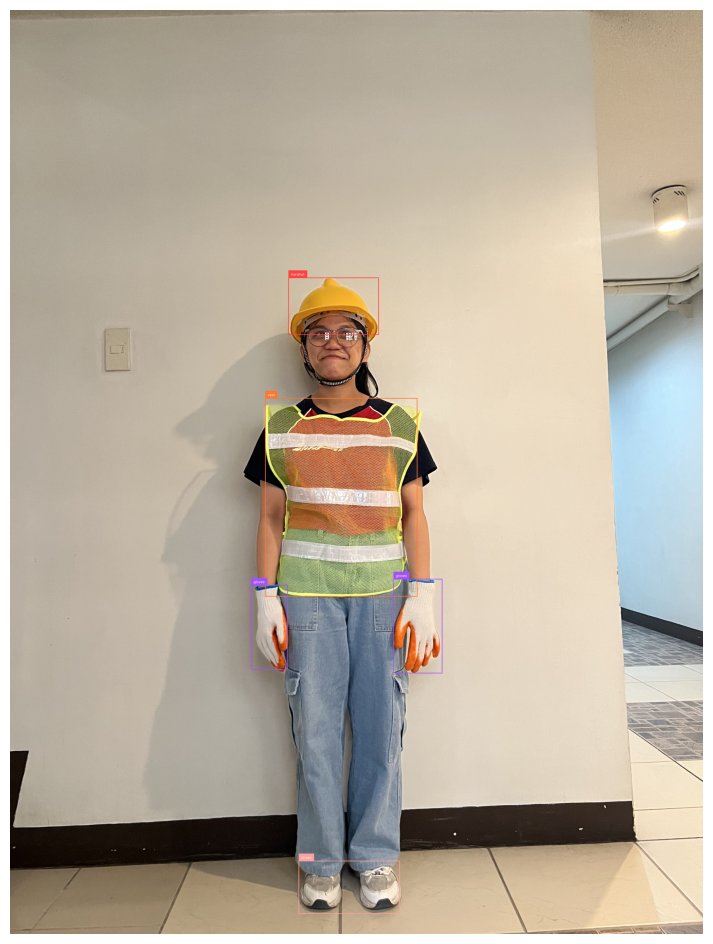

Processing /content/AI-Based-PPE-Detection-Using-Computer-Vision/all/IMG_5660.png...


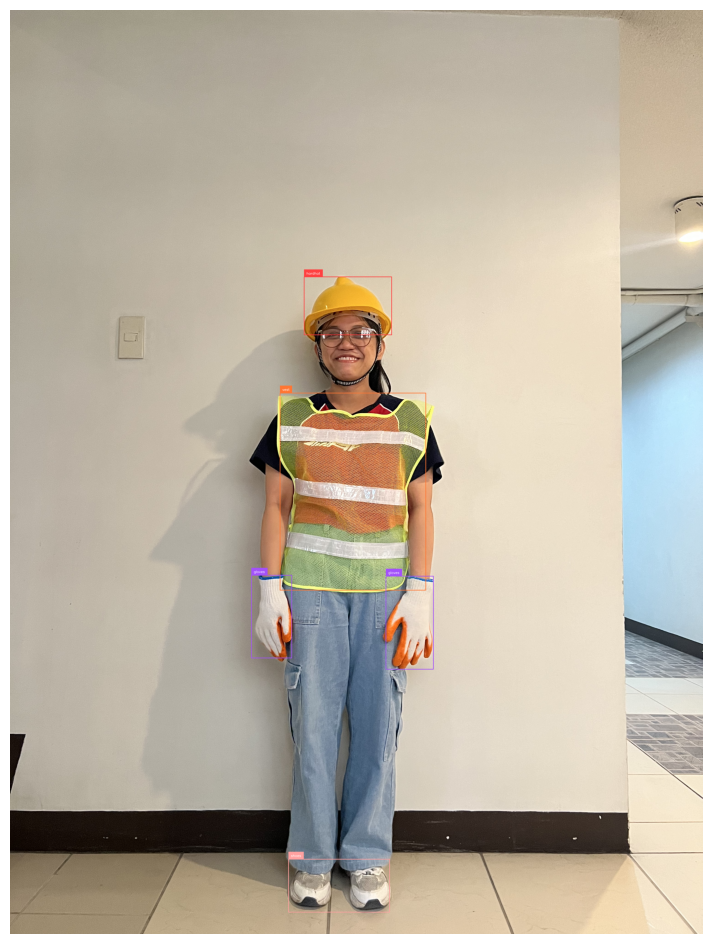

Processing /content/AI-Based-PPE-Detection-Using-Computer-Vision/all/IMG_5658.png...


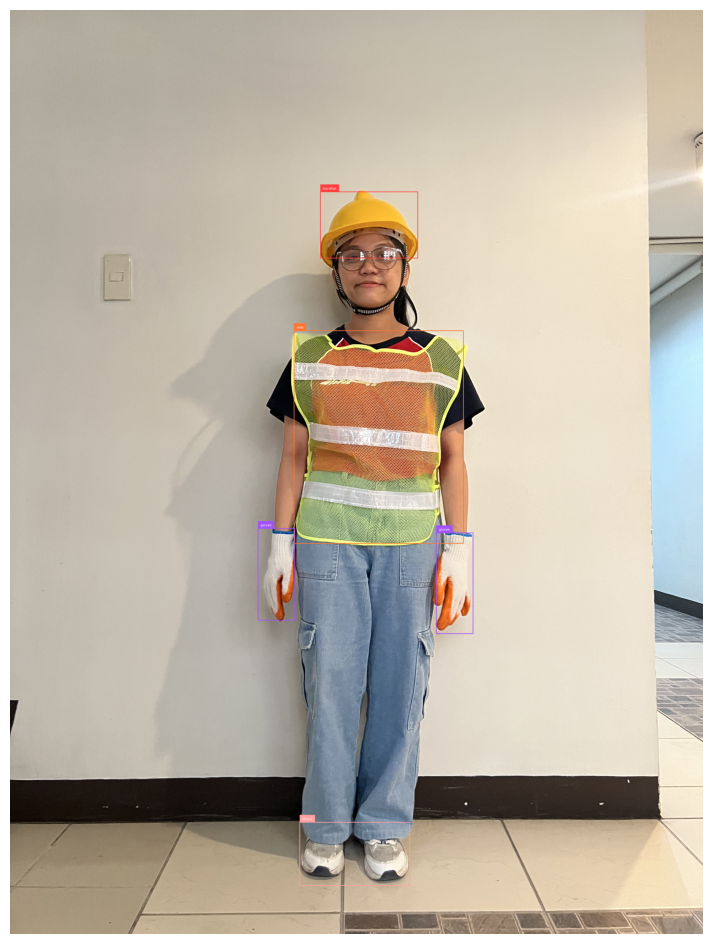


✅ Detection complete! Annotated images saved in: /content/AI-Based-PPE-Detection-Using-Computer-Vision/output


In [23]:
# Test on sample images

import os
import cv2
from inference_sdk import InferenceHTTPClient
import supervision as sv

# initialize Roboflow client
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="ipRXafHM2fxthdHpXUSC"
)

def run_ppe_detection_on_folder(
    input_folder="/content/AI-Based-PPE-Detection-Using-Computer-Vision/all",
    output_folder="/content/AI-Based-PPE-Detection-Using-Computer-Vision/output",
    model_id="ppe-ukjvg/3"
):
    # make sure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # create annotators once
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # loop over all files
    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            file_path = os.path.join(input_folder, filename)
            print(f"Processing {file_path}...")

            # read image
            image = cv2.imread(file_path)

            # run inference
            results = CLIENT.infer(image, model_id=model_id)

            # convert results to detections
            detections = sv.Detections.from_inference(results)

            # annotate image
            annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
            annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

            # save annotated image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, annotated_image)

            # show the annotated image
            sv.plot_image(annotated_image)

    print(f"\n✅ Detection complete! Annotated images saved in: {output_folder}")


# run it
run_ppe_detection_on_folder()

In [24]:
# Calculate IOU

def IOU(bbox1, bbox2):
    """Calculate IoU between two bounding boxes [x, y, w, h]."""
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.0
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

In [26]:
import xml.etree.ElementTree as ET

def parse_voc_xml(xml_file):
    """Parse Pascal VOC .xml file and return list of (class, [x, y, w, h])."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        w = xmax - xmin
        h = ymax - ymin
        objects.append((name, [xmin, ymin, w, h]))
    return objects

In [29]:
def evaluate_iou(image_folder, xml_folder, model_id="ppe-ukjvg/3"):
    results_list = []

    for filename in os.listdir(image_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_folder, filename)
            xml_path = os.path.join(xml_folder, os.path.splitext(filename)[0] + ".xml")

            if not os.path.exists(xml_path):
                print(f"⚠️ Skipping {filename}, no matching XML.")
                continue

            # Read image
            image = cv2.imread(image_path)

            # Inference
            predictions = CLIENT.infer(image, model_id=model_id)
            detections = sv.Detections.from_inference(predictions)

            # Parse ground truth
            ground_truths = parse_voc_xml(xml_path)

            # Compare IoU class-wise
            for pred_class, bbox_xyxy in zip(detections['class_name'], detections.xyxy):
                # Convert [x_min, y_min, x_max, y_max] → [x, y, w, h]
                x_min, y_min, x_max, y_max = bbox_xyxy
                pred_bbox = [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]

                best_iou = 0
                for gt_class, gt_bbox in ground_truths:
                    if pred_class == gt_class:  # only compare same class
                        iou = IOU(pred_bbox, gt_bbox)
                        best_iou = max(best_iou, iou)

                results_list.append({
                    "image": filename,
                    "class": pred_class,
                    "IoU": best_iou
                })

    return results_list


In [30]:

# Example usage
iou_results = evaluate_iou(
    image_folder="/content/AI-Based-PPE-Detection-Using-Computer-Vision/all",
    xml_folder="/content/AI-Based-PPE-Detection-Using-Computer-Vision/all"
)

# Print results
for r in iou_results:
    print(f"{r['image']} - {r['class']} - IoU: {r['IoU']:.2f}")

IMG_5659.png - hardhat - IoU: 0.95
IMG_5659.png - vest - IoU: 0.83
IMG_5659.png - shoes - IoU: 0.86
IMG_5659.png - gloves - IoU: 0.95
IMG_5659.png - gloves - IoU: 0.89
IMG_5660.png - vest - IoU: 0.96
IMG_5660.png - hardhat - IoU: 0.92
IMG_5660.png - gloves - IoU: 0.91
IMG_5660.png - shoes - IoU: 0.89
IMG_5660.png - gloves - IoU: 0.95
IMG_5658.png - gloves - IoU: 0.97
IMG_5658.png - hardhat - IoU: 0.92
IMG_5658.png - vest - IoU: 0.94
IMG_5658.png - gloves - IoU: 0.91
IMG_5658.png - shoes - IoU: 0.90


In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def visualize_iou_grid(image_folder, xml_folder, model_id="ppe-ukjvg/3", num_show=5):
    # Collect image files
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg",".jpeg",".png"))]
    sample_files = random.sample(image_files, min(num_show, len(image_files)))

    plt.figure(figsize=(20, 5))

    for i, filename in enumerate(sample_files):
        image_path = os.path.join(image_folder, filename)
        xml_path = os.path.join(xml_folder, os.path.splitext(filename)[0] + ".xml")

        # Load image
        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Predictions
        predictions_raw = CLIENT.infer(image_bgr, model_id=model_id)
        detections = sv.Detections.from_inference(predictions_raw)

        # Convert predictions to (class, [x,y,w,h])
        preds = []
        for pred_class, bbox_xyxy in zip(detections['class_name'], detections.xyxy):
            x_min, y_min, x_max, y_max = bbox_xyxy
            preds.append((pred_class, [x_min, y_min, x_max - x_min, y_max - y_min]))

        # Ground truth
        gts = parse_voc_xml(xml_path)

        # Pick first pred + first GT (for demo style like your image)
        if preds and gts:
            pred_class, pred_bbox = preds[0]
            gt_class, gt_bbox = gts[0]
            iou = IOU(pred_bbox, gt_bbox)

            print(f"pred={pred_bbox}, act={gt_bbox}, IOU={iou}")

            # Plot
            plt.subplot(1, num_show, i + 1)
            plt.imshow(image_rgb)

            # Draw pred (red)
            px, py, pw, ph = pred_bbox
            plt.gca().add_patch(patches.Rectangle((px, py), pw, ph, edgecolor='r', facecolor='none', linewidth=2))

            # Draw GT (green)
            gx, gy, gw, gh = gt_bbox
            plt.gca().add_patch(patches.Rectangle((gx, gy), gw, gh, edgecolor='g', facecolor='none', linewidth=2))

            plt.axis("off")

    plt.show()



🔍 Processing IMG_5659.png


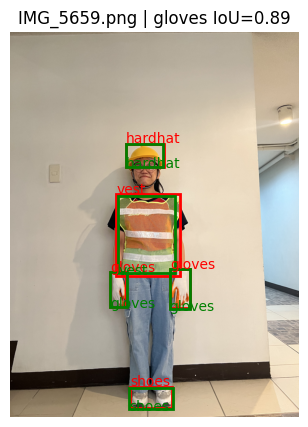


🔍 Processing IMG_5660.png


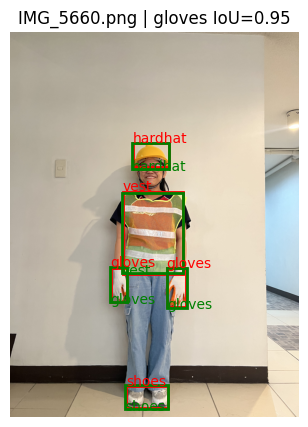


🔍 Processing IMG_5658.png


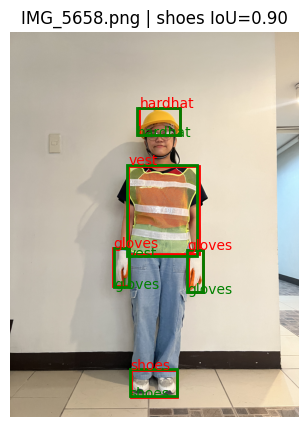

In [45]:
# Loop through all images in the folder
image_folder = "/content/AI-Based-PPE-Detection-Using-Computer-Vision/all"

for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        image_file = os.path.join(image_folder, filename)
        xml_file = os.path.splitext(image_file)[0] + ".xml"

        if not os.path.exists(xml_file):
            print(f"⚠️ Skipping {filename}, no matching XML file.")
            continue

        # Parse GT
        ground_truths = parse_voc_xml(xml_file)

        # Run inference
        predictions_raw = CLIENT.infer(cv2.imread(image_file), model_id="ppe-ukjvg/3")
        detections = sv.Detections.from_inference(predictions_raw)

        # Convert predictions to VOC-style (x,y,w,h)
        predictions = []
        for pred_class, bbox_xyxy in zip(detections['class_name'], detections.xyxy):
            x_min, y_min, x_max, y_max = bbox_xyxy
            predictions.append(
                (pred_class, [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)])
            )

        # Visualize
        print(f"\n🔍 Processing {filename}")
        visualize_iou(image_file, predictions, ground_truths)
